In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import warnings
warnings.filterwarnings('ignore')
# make matplotlib pdf-s text recognizable by evil-Adobe
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from more_itertools import chunked
# import all relevant func and modules from a companion .py file
from supp_lib import *
# import all samples as dictionary ...
from samples import *

In [4]:
genes_df = pd.read_csv(
    "./gene_annot_data/hg19/geneAnnotationsExonUnions.bed",
    sep="\t",
    header=None,
    names = ["chr",
            "txStart",
            "txEnd",
            "geneName",
            "citationCount",
            "strand",
            "union_geneId", # "refseqId",
            "geneId",
            "geneType",
            "geneDesc",
            "cdsStart",
            "cdsEnd",
            "exonStarts",
            "exonEnds"]
)
genes_df.head()

### we'll be removing duplicated genes because they're likely unamppable and/or harder to deal with anyways ...
### there are of course expections, but will do it anyways:
geneId_grp = genes_df.groupby("geneId")
genes_df = geneId_grp.first()[geneId_grp.size() == 1].reset_index()

### Define "active" genes

In [5]:
hap_tss = bioframe.read_table("ActiveTSS-13412-1bp.bed",schema="bed4")
hap_tss = hap_tss.rename(columns={"name":"strand"})


hct_tss = bioframe.read_table("ActiveTSS-13812-1bp_HCT116.bed",schema="bed4")
hct_tss = hct_tss.rename(columns={"name":"strand"})

# # just take a list of common active TSS defined using H3K4me3 sorting both for HAP1 and HCT116:
# common_tss = bioframe.read_table("ActiveTSS-12113-1bp_HCT116_HAP1.bed",schema="bed4")
# common_tss = common_tss.rename(columns={"name":"strand"})

In [6]:
def merge_active_tss_to_genes(genes, active_tss, status_column="status"):
    """
    reasign back active TSS to the genes they were derived from (1bp footprints)
    set their status to "active"
    """
    # reassign back those active TSS to the full list of genes 
    # separately for "+":
    xxx = pd.merge(
        genes,
        active_tss[active_tss["strand"]=="+"],
        how="left",
        left_on=["chr","txStart"],
        right_on=["chrom","start"],
        suffixes=("","2"),
    )
    xxx.loc[~xxx["strand2"].isna(), status_column] = "active"
    # and "-":
    xxx = pd.merge(
        xxx[genes.columns],
        active_tss[active_tss["strand"]=="-"],
        how="left",
        left_on=["chr","txEnd"],
        right_on=["chrom","end"],
        suffixes = ("","2"),
    )
    xxx.loc[~xxx["strand2"].isna(), status_column] = "active"
    
    return xxx[genes.columns]


In [7]:
# common_tss[common_tss["strand"]=="+"][["chrom","start"]] == genes_df[["chr","txStart"]]
genes_df["hap"]="inactive"
genes_df["hct"]="inactive"

xxx = merge_active_tss_to_genes(genes_df, hap_tss, status_column="hap")
xxx = merge_active_tss_to_genes(xxx, hct_tss, status_column="hct")


xxx["status"]="none"
xxx.loc[(xxx["hap"]=="active")&(xxx["hct"]=="active"), "status"] = "active"
xxx.loc[(xxx["hap"]=="inactive")&(xxx["hct"]=="inactive"), "status"] = "inactive"

# refine the dataframe  ...
# columns needed for TSS/TTS bed files output:
tx_cols = ["chr", "txStart", "txEnd", "strand","status"]

tx_cols_rename = {"chr":"chrom",
                  "txStart":"start",
                  "txEnd":"end"}

gdf =  xxx[tx_cols].rename(columns=tx_cols_rename)
gdf["size"] = gdf["end"] - gdf["start"]

# final adjustments ...
gdf = gdf.sort_values(["chrom","start"])
gdf = gdf[gdf["chrom"].isin(autosomal_chroms)]
gdf = gdf.reset_index(drop=True)
gdf.groupby("status").size()

status
active      12233
inactive    11290
none         2927
dtype: int64

#### Let's try to remove genes with CTCF at the promoters(TSS) and TTS - just in case

# here we'd need to replace CTCF with the union of HAP1 and HCT CTCFs !!!

In [8]:
all_genes = copy(gdf)

In [9]:
ctcf_hct_df = bioframe.read_table(
    "CTCF_narrowPeak_HCT116_ENCODE.bed", # CTCF peaks from ENCODE for HCT116
    names=["chrom","start","end"],
    usecols=(0,1,2)
)
ctcf_hct_df = ctcf_hct_df.sort_values(["chrom","start"])
ctcf_hct_df = ctcf_hct_df[ ctcf_hct_df["chrom"].isin(autosomal_chroms) ]
ctcf_hct_df = ctcf_hct_df.reset_index(drop=True)

In [10]:
ctcf_hap_df = bioframe.read_table(
    "NT-CTCF-narrowPeaks-sort-merge-with-strength.bed",  # just our NT CTCF ChipSeq peaks ...
    usecols=(0,1,2),
    names=["chrom","start","end"]
)
ctcf_hap_df = ctcf_hap_df.sort_values(["chrom","start"])
ctcf_hap_df = ctcf_hap_df[ ctcf_hap_df["chrom"].isin(autosomal_chroms) ]
ctcf_hap_df = ctcf_hap_df.reset_index(drop=True)

In [11]:
_df = bioframe.overlap(ctcf_hap_df, ctcf_hct_df, how="outer", return_index=True, suffixes=("_1","_2"))
_df.isna().any(axis=1)

idx2 = _df["index_2"]
idx1 = _df["index_1"]

ctcf_union_df = pd.concat([
            # get HCT indexes, whenever HAP1 is NA
            ctcf_hct_df.loc[ idx2[~idx2.isna()].astype("int") ],
            # get HAP indexes, whenever HCT is NA
            ctcf_hap_df.loc[ idx1[idx2.isna()].astype("int") ]
]).reset_index(drop=True)

ctcf_union_df = ctcf_union_df.drop_duplicates()
ctcf_union_df = ctcf_union_df.sort_values(["chrom","start"])
ctcf_union_df = ctcf_union_df[ ctcf_union_df["chrom"].isin(autosomal_chroms) ]
ctcf_union_df = ctcf_union_df.reset_index(drop=True)
ctcf_union_df.head(3)


,chrom,start,end
0,chr1,10151,10508
1,chr1,237582,237908
2,chr1,714001,714579


In [12]:
from copy import copy

ctcf_radius = 2_000
_tss = copy(all_genes)
_tss["tss"] = _tss.apply(lambda r: r["start"] if r["strand"]=="+" else r["end"],axis=1)
_tss["tss_mflank"] = _tss["tss"] - ctcf_radius
_tss["tss_pflank"] = _tss["tss"] + ctcf_radius
# _tss[["chrom","tss_mflank","tss_pflank"]]

tss_ctcf_overlap = bioframe.overlap(
    _tss[["chrom","tss_mflank","tss_pflank"]],
    ctcf_union_df,
    how='left',
    suffixes=('_', ''),
    return_index=True,
    # keep_order=False,
    cols1=["chrom","tss_mflank","tss_pflank"],
)


_tts = copy(all_genes)
_tts["tts"] = _tts.apply(lambda r: r["end"] if r["strand"]=="+" else r["start"],axis=1)
_tts["tts_mflank"] = _tts["tts"] - ctcf_radius
_tts["tts_pflank"] = _tts["tts"] + ctcf_radius
# _tts[["chrom","tss_mflank","tss_pflank"]]

tts_ctcf_overlap = bioframe.overlap(
    _tts[["chrom","tts_mflank","tts_pflank"]],
    ctcf_union_df,
    how='left',
    suffixes=('_', ''),
    return_index=True,
    # keep_order=False,
    cols1=["chrom","tts_mflank","tts_pflank"],
)

# .drop_duplicates(subset=["chrom_","tss_mflank_","tss_pflank_"])

In [13]:
ctcf_index = tss_ctcf_overlap["index_"][
                    ~pd.isna(tss_ctcf_overlap["index"])
                ]
noctcf_index = tss_ctcf_overlap["index_"][
                    pd.isna(tss_ctcf_overlap["index"])
                ]
ctcf_index = np.unique(ctcf_index.astype(np.int).values)
noctcf_index = np.unique(noctcf_index.astype(np.int).values)

all_genes_ctcf = all_genes.loc[ ctcf_index ].reset_index(drop=True)
all_genes_noctcf = all_genes.loc[ noctcf_index ].reset_index(drop=True)

print(
    f"""{len(all_genes_ctcf)} genes have CTCF@TSS,
    {len(all_genes_noctcf)} genes do not -
    total # of genes {len(all_genes_noctcf)+len(all_genes_ctcf)}"""
)

7842 genes have CTCF@TSS,
    18608 genes do not -
    total # of genes 26450


#### same for TTS ...

In [14]:
ctcf_index = tts_ctcf_overlap["index_"][
                    ~pd.isna(tts_ctcf_overlap["index"])
                ]
noctcf_index = tts_ctcf_overlap["index_"][
                    pd.isna(tts_ctcf_overlap["index"])
                ]
ctcf_index = np.unique(ctcf_index.astype(np.int).values)
noctcf_index = np.unique(noctcf_index.astype(np.int).values)

all_genes_ctcf = all_genes.loc[ ctcf_index ].reset_index(drop=True)
all_genes_noctcf = all_genes.loc[ noctcf_index ].reset_index(drop=True)

print(
    f"""{len(all_genes_ctcf)} genes have CTCF@TTS,
    {len(all_genes_noctcf)} genes do not -
    total # of genes {len(all_genes_noctcf)+len(all_genes_ctcf)}"""
)

4428 genes have CTCF@TTS,
    22022 genes do not -
    total # of genes 26450


#### Combine "exclusion" of CTCF for both TSS and TTS ...

In [15]:
ctcf_index_tts = tts_ctcf_overlap["index_"][
                    ~pd.isna(tts_ctcf_overlap["index"])
                ]
noctcf_index_tts = tts_ctcf_overlap["index_"][
                    pd.isna(tts_ctcf_overlap["index"])
                ]
# these are indices of the genes (from all_genes) that have (don't have) CTCF@TTS
ctcf_index_tts = np.unique(ctcf_index_tts.astype(np.int).values)
noctcf_index_tts = np.unique(noctcf_index_tts.astype(np.int).values)


ctcf_index_tss = tss_ctcf_overlap["index_"][
                    ~pd.isna(tss_ctcf_overlap["index"])
                ]
noctcf_index_tss = tss_ctcf_overlap["index_"][
                    pd.isna(tss_ctcf_overlap["index"])
                ]
# these are indices of the genes (from all_genes) that have (don't have) CTCF@TSS
ctcf_index_tss = np.unique(ctcf_index_tss.astype(np.int).values)
noctcf_index_tss = np.unique(noctcf_index_tss.astype(np.int).values)

# here is the strictest set - no CTCF at TSS AND TTS ...
strict_index = np.intersect1d(
                        noctcf_index_tts,
                        noctcf_index_tss
                )

all_genes_noctcf_atall = all_genes.loc[ strict_index ].reset_index(drop=True)

print(
    f"""{len(all_genes_noctcf_atall)} genes have no CTCF@TTS and no CTCF@TSS"""
)

16295 genes have no CTCF@TTS and no CTCF@TSS


### Use `gdf` variable to choose which DataFrame with genes we are going to work on  ....

In [16]:
gdf = copy(all_genes_noctcf_atall)

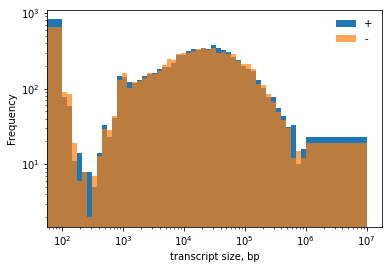

In [17]:
bins = np.r_[0,np.geomspace(100,1_000_000),10_000_000]
gdf[gdf["strand"]=="+"]["size"].plot.hist(bins=bins,log=True,label="+")
gdf[gdf["strand"]=="-"]["size"].plot.hist(bins=bins,log=True,alpha=0.7,label="-")
ax = plt.gca()
ax.set_xscale("log")
ax.set_xlabel("transcript size, bp")
ax.legend(frameon=False)

In [18]:
# categorize by the size
sizes_bin_edges = [0,50_000,np.inf]
sizes_labels = ("short","long")

gdf["gsize"] = pd.cut(
    gdf["size"],
    bins = sizes_bin_edges,
    labels = sizes_labels,
    include_lowest = True
)
display(gdf.head(2))
display( gdf.groupby(["status","gsize"]).size().unstack(fill_value=0) )

,chrom,start,end,strand,status,size,gsize
0,chr1,14361,29370,-,active,15009,short
1,chr1,69090,70008,+,inactive,918,short


gsize,short,long
status,,
active,3813,1925
inactive,7465,1471
none,1148,473


In [19]:
# extend the stacking region by the gene length on each side !
gdf["start"] = gdf["start"] - gdf["size"]
gdf["end"] = gdf["end"] + gdf["size"]

In [27]:
# 'ev1_CTCF', 'ev1_noCTCF', 'ev1_polII', 'ev1_nopolII'
def extract_rescaled_stack(df,
                fname,
                bins=3000
               ):
    """
    for a BED-like DF, extract 'signal' from BW (fname) for every interval
    use "strand" information to flip "-" strand genes ...
    """
    return np.asarray([
        bbi.fetch
               (
                    fname,
                    chrom,
                    start,
                    end,
                    bins=bins,
                    missing=0.0,
                    oob=np.nan,
                    summary='mean',
                )[:: (1 if strand=="+" else -1) ] # flip in place for "-" genes
      for chrom, start, end, strand, *_ in df.itertuples(index=False)
    ])



# 'ev1_CTCF', 'ev1_noCTCF', 'ev1_polII', 'ev1_nopolII'
def extract_ins(df,
                fname,
                bins=3000
               ):
    """
    for a BED-like DF, extract 'signal' from BW (fname) for every interval
    use "strand" information to flip "-" strand genes ...
    """
    return np.nanmean(np.asarray([
        bbi.fetch
               (
                    fname,
                    chrom,
                    start,
                    end,
                    bins=bins,
                    missing=0.0,
                    oob=np.nan,
                    summary='mean',
                )[:: (1 if strand=="+" else -1) ] # flip in place for "-" genes
      for chrom, start, end, strand, *_ in df.itertuples(index=False)
    ]),
      axis=0,                
     )


def extract_ins_noflip(df,
                fname,
                bins=3000
               ):
    """
    for a BED-like DF, extract 'signal' from BW (fname) for every interval
    no flipping ...
    """
    return np.nanmean(np.asarray([
        bbi.fetch
               (
                    fname,
                    chrom,
                    start,
                    end,
                    bins=bins,
                    missing=0.0,
                    oob=np.nan,
                    summary='mean',
                )
      for chrom, start, end, *_ in df.itertuples(index=False)
    ]),
      axis=0,                
     )


In [21]:
ctcf_df = bioframe.read_table("CTCF-peaks-no-activeTSS-with-RAD21-centered",schema="bed3",index_col=False)
# # ctcf_df = pd.read_table("intersect-all-NT-CTCF-NO-G4-centered-RAD21",header=None)
ctcf_df = ctcf_df.sort_values(["chrom","start"])
ctcf_df = ctcf_df[ctcf_df["chrom"].isin(autosomal_chroms)]
ctcf_df = ctcf_df.reset_index(drop=True)
ctcf_df["start"] = ctcf_df["start"] - 200_000
ctcf_df["end"] = ctcf_df["end"] + 200_000
ctcf_df.head(3)

,chrom,start,end
0,chr1,-189849,210508
1,chr1,604937,1005691
2,chr1,639840,1040454


### TSS to TTS scaled profiles ...

In [22]:
# key features/signals that we want to extract for our genes ...
key_features  = [
                "ins_noTIR1_500M",  # 500M reads to make em equally-deep
                "ins_CTCF_500M",  # 500M reads to make em equally-deep
                "ins_noCTCF_500M",  # 500M reads to make em equally-deep
                "ins_polII",
                "ins_nopolII",
                "ins_rad21",
                "ins_norad21",
                "ins_waplWT",
                "ins_waplKO1",
                "ins_waplKO3",
                "Rloop_K562",
                "rad21_CTCF",
                "rad21_noCTCF",
                "rad21_wt1",
                "rad21_rad21",
                "rad21_norad21",
                "newrad21_PolII",
                "newrad21_noPolII",
                ]

### Extracting Meta-gene profiles of the key-features (insulations, Chip_Seq data etc)

#### Here we extract data for + and - genes separately and flip "-" genes to orient them same way as the "+" genes ...
#### using `extract_ins` function...

In [23]:
profiles_dict = {}

# group genes by expression and size before extracting corresponding profiles of a list of features :
gene_groups = gdf.groupby(["status","gsize"])
for feature_name in key_features:
    print(f"extracting {feature_name} for the genes ...")
    feature_fname = samples[feature_name]["fname"]
    profiles_dict[feature_name] = gene_groups.apply( lambda sub_df: extract_ins(sub_df, feature_fname) )

extracting ins_noTIR1_500M for the genes ...
extracting ins_CTCF_500M for the genes ...
extracting ins_noCTCF_500M for the genes ...
extracting ins_polII for the genes ...
extracting ins_nopolII for the genes ...
extracting ins_rad21 for the genes ...
extracting ins_norad21 for the genes ...
extracting ins_waplWT for the genes ...
extracting ins_waplKO1 for the genes ...
extracting ins_waplKO3 for the genes ...
extracting Rloop_K562 for the genes ...
extracting rad21_CTCF for the genes ...
extracting rad21_noCTCF for the genes ...
extracting rad21_wt1 for the genes ...
extracting rad21_rad21 for the genes ...
extracting rad21_norad21 for the genes ...
extracting newrad21_PolII for the genes ...
extracting newrad21_noPolII for the genes ...


In [28]:
# extract_rescaled_stack

stacks_dict = {}

# group genes by expression and size before extracting corresponding profiles of a list of features :
gene_groups = gdf.groupby(["status","gsize"])
for feature_name in key_features:
    print(f"extracting {feature_name} for the genes ...")
    feature_fname = samples[feature_name]["fname"]
    stacks_dict[feature_name] = gene_groups.apply( lambda sub_df: extract_rescaled_stack(sub_df, feature_fname) )

extracting ins_noTIR1_500M for the genes ...
extracting ins_CTCF_500M for the genes ...
extracting ins_noCTCF_500M for the genes ...
extracting ins_polII for the genes ...
extracting ins_nopolII for the genes ...
extracting ins_rad21 for the genes ...
extracting ins_norad21 for the genes ...
extracting ins_waplWT for the genes ...
extracting ins_waplKO1 for the genes ...
extracting ins_waplKO3 for the genes ...
extracting Rloop_K562 for the genes ...
extracting rad21_CTCF for the genes ...
extracting rad21_noCTCF for the genes ...
extracting rad21_wt1 for the genes ...
extracting rad21_rad21 for the genes ...
extracting rad21_norad21 for the genes ...
extracting newrad21_PolII for the genes ...
extracting newrad21_noPolII for the genes ...


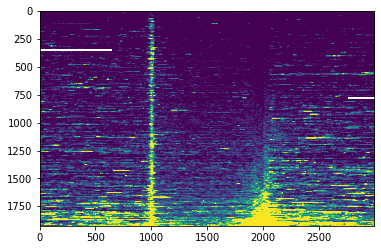

In [50]:
sort_metric = stacks_dict["Rloop_K562"]["active","long"][:,2000-100:2000+50].mean(axis=1)
iiii = np.argsort(sort_metric)
plt.imshow(stacks_dict["Rloop_K562"]["active","long"][iiii,:],vmin=1,vmax=4)

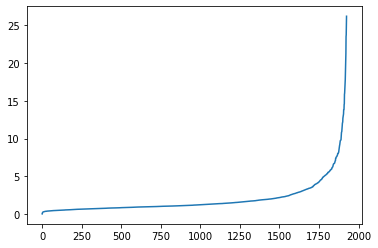

In [51]:
plt.plot(sort_metric[iiii])

### CTCF insulation/Rloops profiles to match the scaled TSS/TTS profiles ...

#### In this case we are not flipping profiles according to orientation (yet), so we have to use `extract_ins_noflip` function

In [24]:
CTCF_profiles_dict = {}

for feature_name in key_features:
    print(f"extracting {feature_name} for the CTCF peaks ...")
    feature_fname = samples[feature_name]["fname"]
    CTCF_profiles_dict[feature_name] = extract_ins_noflip(ctcf_df, feature_fname, bins=300)

extracting ins_noTIR1_500M for the CTCF peaks ...
extracting ins_CTCF_500M for the CTCF peaks ...
extracting ins_noCTCF_500M for the CTCF peaks ...
extracting ins_polII for the CTCF peaks ...
extracting ins_nopolII for the CTCF peaks ...
extracting ins_rad21 for the CTCF peaks ...
extracting ins_norad21 for the CTCF peaks ...
extracting ins_waplWT for the CTCF peaks ...
extracting ins_waplKO1 for the CTCF peaks ...
extracting ins_waplKO3 for the CTCF peaks ...
extracting Rloop_K562 for the CTCF peaks ...
extracting rad21_CTCF for the CTCF peaks ...
extracting rad21_noCTCF for the CTCF peaks ...
extracting rad21_wt1 for the CTCF peaks ...
extracting rad21_rad21 for the CTCF peaks ...
extracting rad21_norad21 for the CTCF peaks ...
extracting newrad21_PolII for the CTCF peaks ...
extracting newrad21_noPolII for the CTCF peaks ...


### Normalize insulation by subtracting average flanking signal

In [25]:
ins_keys = [k for k in key_features if k.startswith("ins") ]

for feature_name in ins_keys:
    print(f"normalizing insulation {feature_name} for CTCF-peak profiles ...")
    ins_profile = CTCF_profiles_dict[feature_name]
    flank_size = int(len(ins_profile)*0.25)
    # average left and right shoulders of `flank_size` ...
    average_signal_across_flank = np.nanmean(np.r_[ins_profile[:flank_size], ins_profile[-flank_size:]])
    # subtract that average flank ...
    CTCF_profiles_dict[feature_name] = CTCF_profiles_dict[feature_name] - average_signal_across_flank
    

for feature_name in ins_keys:
    print(f"normalizing insulation {feature_name} for gene profiles ...")
    for gexp_gsize_key, ins_profile in profiles_dict[feature_name].iteritems():
        flank_size = int(len(ins_profile)*0.25)
        # average left and right shoulders of `flank_size` ...
        average_signal_across_flank = np.nanmean(np.r_[ins_profile[:flank_size], ins_profile[-flank_size:]])
        # subtract that average flank ...
        profiles_dict[feature_name][gexp_gsize_key] = ins_profile - average_signal_across_flank


normalizing insulation ins_noTIR1_500M for CTCF-peak profiles ...
normalizing insulation ins_CTCF_500M for CTCF-peak profiles ...
normalizing insulation ins_noCTCF_500M for CTCF-peak profiles ...
normalizing insulation ins_polII for CTCF-peak profiles ...
normalizing insulation ins_nopolII for CTCF-peak profiles ...
normalizing insulation ins_rad21 for CTCF-peak profiles ...
normalizing insulation ins_norad21 for CTCF-peak profiles ...
normalizing insulation ins_waplWT for CTCF-peak profiles ...
normalizing insulation ins_waplKO1 for CTCF-peak profiles ...
normalizing insulation ins_waplKO3 for CTCF-peak profiles ...
normalizing insulation ins_noTIR1_500M for gene profiles ...
normalizing insulation ins_CTCF_500M for gene profiles ...
normalizing insulation ins_noCTCF_500M for gene profiles ...
normalizing insulation ins_polII for gene profiles ...
normalizing insulation ins_nopolII for gene profiles ...
normalizing insulation ins_rad21 for gene profiles ...
normalizing insulation ins_

#### Plotting the profiles ...

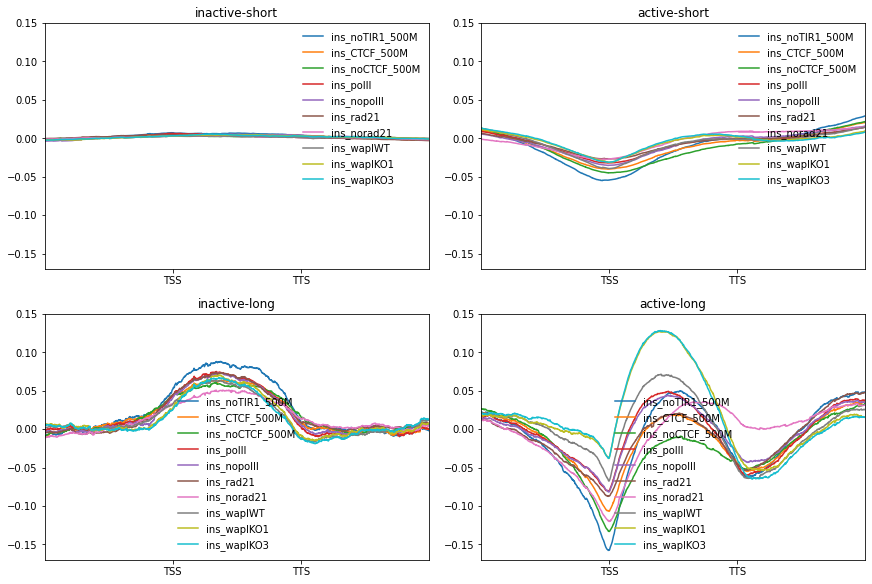

In [26]:
glens=("short","long")
gexps=("inactive","active")

fig = plt.figure(figsize=(12,8),constrained_layout=True)
gs = fig.add_gridspec(len(glens),len(gexps))

for i,glen in enumerate(glens):
    for j,gexp in enumerate(gexps):
        ax = fig.add_subplot(gs[i,j])
        for feature_name in ins_keys:
            ins_profiles = profiles_dict[feature_name]
            ax.plot(ins_profiles[(gexp,glen)],label=feature_name)
        ax.set_title(f"{gexp}-{glen}")
        ax.legend(frameon=False)
        ax.set_ylim(-0.17,.15)
        ax.set_xlim(0,3000)
        ax.set_xticks([1000,2000])
        ax.set_xticklabels(["TSS","TTS"])

### Figure 2B itself ! comparing average insulation

In [42]:
def plot_one_row(fig, gs, row_id, profile_keys, ylim, show_title=False, show_ticks=False):
    # CTCF profiles ...
    ax = fig.add_subplot(gs[row_id,0])
    for feature_name in profile_keys:
        ins_profile = CTCF_profiles_dict[feature_name]
        ax.plot(ins_profile,label=feature_name)
    if show_title:
        ax.set_title(f"CTCF sites (w RAD21, wo G4)")
    # ax.legend(frameon=False)
    ax.set_ylim(ylim)
    ax.set_xlim(0,300)
    if show_ticks:
        ax.set_xticks([0,300])
        ax.set_xticklabels(["-200kb","200kb"])
        tickl, tickr = ax.get_xticklabels()
        tickl.set_ha("left")
        tickr.set_ha("right")
    else:
        ax.set_xticks([])
    
    # insulation profiles around genes ...
    glen="long"
    gexps=["active",]
    # gexps=("active","inactive")
    for j, gexp in enumerate(gexps):
        ax = fig.add_subplot(gs[row_id,j+1])
        for feature_name in profile_keys:
            ins_profiles = profiles_dict[feature_name]
            ax.plot(ins_profiles[(gexp,glen)],label=feature_name)
        if show_title:
            ax.set_title(f"{gexp}-{glen}")
        ax.legend(frameon=False)
        ax.set_ylim(ylim)
        ax.set_xlim(0,3000)
        ax.set_yticks([])
        if show_ticks:
            ax.set_xticks([1000,2000])
            ax.set_xticklabels(["TSS","TTS"])
        else:
            ax.set_xticks([])

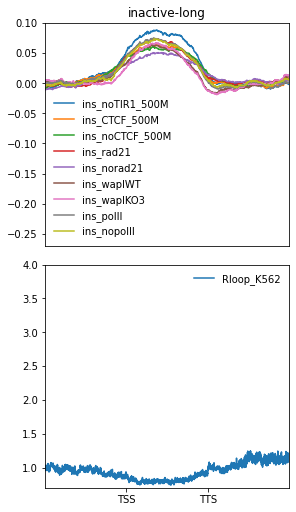

In [43]:
fig = plt.figure(figsize=(4,7),constrained_layout=True)
gs = fig.add_gridspec(2,1)
ins_ylim = (-0.27,.1)


ins_profile_keys = ["ins_noTIR1_500M", "ins_CTCF_500M", "ins_noCTCF_500M"] + \
                    ["ins_rad21", "ins_norad21"] + \
                    ["ins_waplWT","ins_waplKO3"] + \
                    ["ins_polII", 'ins_nopolII']

# R-loop profiles around inactive genes ...
glen="long"
gexp="inactive"
ax = fig.add_subplot(gs[0,0])
for feature_name in ins_profile_keys:
    ins_profiles = profiles_dict[feature_name]
    ax.plot(ins_profiles[(gexp,glen)],label=feature_name)
ax.set_title(f"{gexp}-{glen}")
ax.legend(frameon=False)
ax.set_ylim(ins_ylim)
ax.set_xlim(0,3000)
ax.set_xticks([])

# R-loop profiles around inactive genes ...
ax = fig.add_subplot(gs[1,0])
feature_name = "Rloop_K562"
ins_profiles = profiles_dict[feature_name]
ax.plot(ins_profiles[(gexp,glen)],label=feature_name)
ax.legend(frameon=False)
ax.set_ylim((.7,4.))
ax.set_xlim(0,3000)
ax.set_xticks([1000,2000])
ax.set_xticklabels(["TSS","TTS"])

plt.savefig("SuppFig2E_accross_inactive_genes_December.pdf")

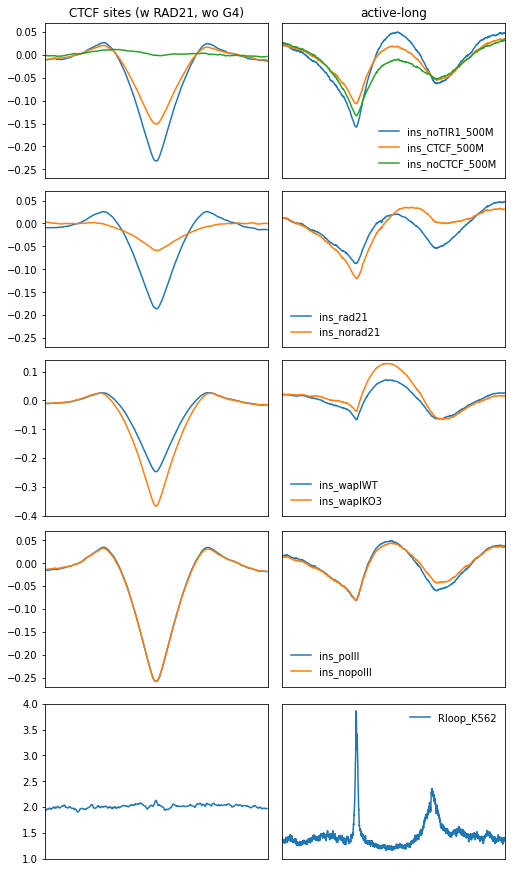

In [51]:
fig = plt.figure(figsize=(7,12),constrained_layout=True)
gs = fig.add_gridspec(5,2)

ins_ylim = (-0.27,.07)
# upper set of insulation profiles ...
plot_one_row(fig, gs, 0, ["ins_noTIR1_500M", "ins_CTCF_500M", "ins_noCTCF_500M"],ins_ylim, show_title=True)
# another set of insulation profiles ...
plot_one_row(fig, gs, 1, ["ins_rad21", "ins_norad21"],ins_ylim)
plot_one_row(fig, gs, 2, ["ins_waplWT","ins_waplKO3"],(-0.4,.14))
plot_one_row(fig, gs, 3, ["ins_polII", 'ins_nopolII'],ins_ylim)



# another set of insulation profiles ...
rloop_ylim = (.99,4.)
plot_one_row(fig, gs, 4, ["Rloop_K562"],rloop_ylim,show_ticks=False)

# plot_one_row(fig, gs, 5, ["rad21_CTCF", "rad21_noCTCF"],(0,.07),show_ticks=True)
# plot_one_row(fig, gs, 6, [ "newrad21_PolII", "newrad21_noPolII"],(0,.2),show_ticks=True)
# plot_one_row(fig, gs, 7, ["rad21_rad21", "rad21_norad21"],(0,1),show_ticks=True)

# plt.savefig("Fig2B_accross_gene_December.pdf")

In [70]:
! scp Fig2B_accross_gene_December.pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
! scp SuppFig2E_accross_inactive_genes_December.pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/

Fig2B_accross_gene_December.pdf               100%  475KB   3.8MB/s   00:00    
SuppFig2E_accross_inactive_genes_December.pdf 100%  487KB   3.9MB/s   00:00    
